In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:

xy = pd.read_parquet('XY_version1.parquet')
xy.head()

,year,area,avg_yield_maize_corn_1y,avg_yield_maize_corn_3y,avg_yield_maize_corn_6y,avg_yield_other_vegetables_fresh_nec_1y,avg_yield_other_vegetables_fresh_nec_3y,avg_yield_other_vegetables_fresh_nec_6y,avg_yield_potatoes_1y,avg_yield_potatoes_3y,...,Y_oil_palm_fruit,Y_other_vegetables_fresh_nec,Y_potatoes,Y_rice,Y_soya_beans,Y_sugar_beet,Y_sugar_cane,Y_tomatoes,Y_watermelons,Y_wheat
0,1983,Afghanistan,1665.8,1668.633333,1636.283333,6919.2,6846.166667,6561.216667,15511.4,15265.133333,...,NaN,7065.7,15764.7,2258.1,NaN,20000.0,19375.0,NaN,9754.9,1258.0
1,1984,Afghanistan,1664.1,1666.300000,1649.750000,7065.7,6959.033333,6775.366667,15764.7,15566.600000,...,NaN,7155.1,14444.4,2241.6,NaN,20000.0,19354.8,NaN,9630.0,1231.9
2,1985,Afghanistan,1661.2,1663.700000,1656.900000,7155.1,7046.666667,6897.800000,14444.4,15240.166667,...,NaN,7145.9,14090.9,2248.2,NaN,3333.3,19333.3,NaN,9556.7,1227.7
3,1986,Afghanistan,1665.2,1663.500000,1666.066667,7145.9,7122.233333,6984.200000,14090.9,14766.666667,...,NaN,7249.5,15866.7,2240.0,NaN,12500.0,20000.0,NaN,10058.8,1189.0
4,1987,Afghanistan,1687.5,1671.300000,1668.800000,7249.5,7183.500000,7071.266667,15866.7,14800.666667,...,NaN,7524.8,15500.0,2000.0,NaN,15000.0,20000.0,NaN,9952.9,1284.9


In [3]:
latlong  = pd.read_csv('coordinates_countries_full_209.csv')
latlong['area'] = latlong['Area'].str.replace(' ', '_')
latlong = latlong[['area', 'latitude', 'longitude']]

In [4]:
xy = xy.merge(latlong, on='area')
xy = pd.get_dummies(xy, columns=['area'])
xy.columns = (
    xy.columns
    .str.strip()             # remove leading/trailing spaces
    .str.replace(' ', '_')   # replace spaces
    .str.replace(r'[^A-Za-z0-9_]', '', regex=True)  # remove special chars
)
xy.columns.tolist()

['year',
 'avg_yield_maize_corn_1y',
 'avg_yield_maize_corn_3y',
 'avg_yield_maize_corn_6y',
 'avg_yield_other_vegetables_fresh_nec_1y',
 'avg_yield_other_vegetables_fresh_nec_3y',
 'avg_yield_other_vegetables_fresh_nec_6y',
 'avg_yield_potatoes_1y',
 'avg_yield_potatoes_3y',
 'avg_yield_potatoes_6y',
 'avg_yield_rice_1y',
 'avg_yield_rice_3y',
 'avg_yield_rice_6y',
 'avg_yield_sugar_cane_1y',
 'avg_yield_sugar_cane_3y',
 'avg_yield_sugar_cane_6y',
 'avg_yield_wheat_1y',
 'avg_yield_wheat_3y',
 'avg_yield_wheat_6y',
 'avg_yield_oil_palm_fruit_1y',
 'avg_yield_oil_palm_fruit_3y',
 'avg_yield_oil_palm_fruit_6y',
 'avg_yield_barley_1y',
 'avg_yield_barley_3y',
 'avg_yield_barley_6y',
 'avg_yield_soya_beans_1y',
 'avg_yield_soya_beans_3y',
 'avg_yield_soya_beans_6y',
 'avg_yield_sugar_beet_1y',
 'avg_yield_sugar_beet_3y',
 'avg_yield_sugar_beet_6y',
 'avg_yield_watermelons_1y',
 'avg_yield_watermelons_3y',
 'avg_yield_watermelons_6y',
 'avg_yield_cucumbers_and_gherkins_1y',
 'avg_yield_cuc

In [5]:
features_col =[
 'avg_yield_maize_corn_1y',
 'avg_yield_maize_corn_3y',
 'avg_yield_maize_corn_6y',
 'avg_yield_other_vegetables_fresh_nec_1y',
 'avg_yield_other_vegetables_fresh_nec_3y',
 'avg_yield_other_vegetables_fresh_nec_6y',
 'avg_yield_potatoes_1y',
 'avg_yield_potatoes_3y',
 'avg_yield_potatoes_6y',
 'avg_yield_rice_1y',
 'avg_yield_rice_3y',
 'avg_yield_rice_6y',
 'avg_yield_sugar_cane_1y',
 'avg_yield_sugar_cane_3y',
 'avg_yield_sugar_cane_6y',
 'avg_yield_wheat_1y',
 'avg_yield_wheat_3y',
 'avg_yield_wheat_6y',
 'avg_yield_oil_palm_fruit_1y',
 'avg_yield_oil_palm_fruit_3y',
 'avg_yield_oil_palm_fruit_6y',
 'avg_yield_barley_1y',
 'avg_yield_barley_3y',
 'avg_yield_barley_6y',
 'avg_yield_soya_beans_1y',
 'avg_yield_soya_beans_3y',
 'avg_yield_soya_beans_6y',
 'avg_yield_sugar_beet_1y',
 'avg_yield_sugar_beet_3y',
 'avg_yield_sugar_beet_6y',
 'avg_yield_watermelons_1y',
 'avg_yield_watermelons_3y',
 'avg_yield_watermelons_6y',
 'avg_yield_cucumbers_and_gherkins_1y',
 'avg_yield_cucumbers_and_gherkins_3y',
 'avg_yield_cucumbers_and_gherkins_6y',
 'avg_yield_tomatoes_1y',
 'avg_yield_tomatoes_3y',
 'avg_yield_tomatoes_6y',
 'avg_yield_bananas_1y',
 'avg_yield_bananas_3y',
 'avg_yield_bananas_6y',
 'avg_yield_cassava_fresh_1y',
 'avg_yield_cassava_fresh_3y',
 'avg_yield_cassava_fresh_6y',
 'rain_Jan',
 'rain_Feb',
 'rain_Mar',
 'rain_Apr',
 'rain_May',
 'rain_Jun',
 'rain_Jul',
 'rain_Aug',
 'rain_Sep',
 'rain_Oct',
 'rain_Nov',
 'rain_Dec',
 'avg_rain_1_3',
 'avg_rain_3_6',
 'avg_rain_6_9',
 'avg_rain_10_12',
 'avg_rain_1_12',
 'solar_Jan',
 'solar_Feb',
 'solar_Mar',
 'solar_Apr',
 'solar_May',
 'solar_Jun',
 'solar_Jul',
 'solar_Aug',
 'solar_Sep',
 'solar_Oct',
 'solar_Nov',
 'solar_Dec',
 'avg_solar_1_3',
 'avg_solar_3_6',
 'avg_solar_6_9',
 'avg_solar_10_12',
 'avg_solar_1_12',
 'temp_Jan',
 'temp_Feb',
 'temp_Mar',
 'temp_Apr',
 'temp_May',
 'temp_Jun',
 'temp_Jul',
 'temp_Aug',
 'temp_Sep',
 'temp_Oct',
 'temp_Nov',
 'temp_Dec',
 'avg_temp_1_3',
 'avg_temp_3_6',
 'avg_temp_6_9',
 'avg_temp_10_12',
 'avg_temp_1_12',
 'sum_rain_1_3',
 'sum_rain_3_6',
 'sum_rain_6_9',
 'sum_rain_10_12',
 'sum_rain_1_12',

 'latitude',
 'longitude',
 'area_Afghanistan',
 'area_Albania',
 'area_Algeria',
 'area_Angola',
 'area_Antigua_and_Barbuda',
 'area_Argentina',
 'area_Armenia',
 'area_Australia',
 'area_Austria',
 'area_Azerbaijan',
 'area_Bahamas',
 'area_Bangladesh',
 'area_Barbados',
 'area_Belarus',
 'area_Belgium',
 'area_BelgiumLuxembourg',
 'area_Belize',
 'area_Benin',
 'area_Bhutan',
 'area_Bolivia_Plurinational_State_of',
 'area_Bosnia_and_Herzegovina',
 'area_Botswana',
 'area_Brazil',
 'area_Bulgaria',
 'area_Burkina_Faso',
 'area_Burundi',
 'area_Cabo_Verde',
 'area_Cambodia',
 'area_Cameroon',
 'area_Canada',
 'area_Central_African_Republic',
 'area_Chad',
 'area_Chile',
 'area_China',
 'area_China_Taiwan_Province_of',
 'area_China_mainland',
 'area_Colombia',
 'area_Comoros',
 'area_Congo',
 'area_Costa_Rica',
 'area_Croatia',
 'area_Cuba',
 'area_Czechia',
 'area_Czechoslovakia',
 'area_Cte_dIvoire',
 'area_Democratic_Peoples_Republic_of_Korea',
 'area_Democratic_Republic_of_the_Congo',
 'area_Denmark',
 'area_Djibouti',
 'area_Dominica',
 'area_Dominican_Republic',
 'area_Ecuador',
 'area_Egypt',
 'area_El_Salvador',
 'area_Eritrea',
 'area_Eswatini',
 'area_Ethiopia',
 'area_Ethiopia_PDR',
 'area_Fiji',
 'area_France',
 'area_French_Guiana',
 'area_Gabon',
 'area_Gambia',
 'area_Georgia',
 'area_Germany',
 'area_Ghana',
 'area_Greece',
 'area_Grenada',
 'area_Guatemala',
 'area_Guinea',
 'area_GuineaBissau',
 'area_Guyana',
 'area_Haiti',
 'area_Honduras',
 'area_Hungary',
 'area_India',
 'area_Indonesia',
 'area_Iran_Islamic_Republic_of',
 'area_Iraq',
 'area_Israel',
 'area_Italy',
 'area_Jamaica',
 'area_Japan',
 'area_Jordan',
 'area_Kazakhstan',
 'area_Kenya',
 'area_Kuwait',
 'area_Kyrgyzstan',
 'area_Lao_Peoples_Democratic_Republic',
 'area_Lebanon',
 'area_Lesotho',
 'area_Libya',
 'area_Lithuania',
 'area_Luxembourg',
 'area_Madagascar',
 'area_Malawi',
 'area_Malaysia',
 'area_Maldives',
 'area_Mali',
 'area_Mauritania',
 'area_Mauritius',
 'area_Mexico',
 'area_Micronesia_Federated_States_of',
 'area_Montenegro',
 'area_Morocco',
 'area_Mozambique',
 'area_Myanmar',
 'area_Namibia',
 'area_Nepal',
 'area_Netherlands_Kingdom_of_the',
 'area_New_Caledonia',
 'area_New_Zealand',
 'area_Nicaragua',
 'area_Niger',
 'area_Nigeria',
 'area_North_Macedonia',
 'area_Oman',
 'area_Pakistan',
 'area_Panama',
 'area_Papua_New_Guinea',
 'area_Paraguay',
 'area_Peru',
 'area_Philippines',
 'area_Poland',
 'area_Portugal',
 'area_Puerto_Rico',
 'area_Qatar',
 'area_Republic_of_Korea',
 'area_Republic_of_Moldova',
 'area_Romania',
 'area_Russian_Federation',
 'area_Rwanda',
 'area_Runion',
 'area_Saint_Vincent_and_the_Grenadines',
 'area_Sao_Tome_and_Principe',
 'area_Saudi_Arabia',
 'area_Senegal',
 'area_Serbia',
 'area_Serbia_and_Montenegro',
 'area_Sierra_Leone',
 'area_Slovakia',
 'area_Slovenia',
 'area_Somalia',
 'area_South_Africa',
 'area_South_Sudan',
 'area_Spain',
 'area_Sri_Lanka',
 'area_Sudan',
 'area_Sudan_former',
 'area_Suriname',
 'area_Sweden',
 'area_Switzerland',
 'area_Syrian_Arab_Republic',
 'area_Tajikistan',
 'area_Thailand',
 'area_TimorLeste',
 'area_Togo',
 'area_Trinidad_and_Tobago',
 'area_Turkmenistan',
 'area_Trkiye',
 'area_USSR',
 'area_Uganda',
 'area_Ukraine',
 'area_United_Arab_Emirates',
 'area_United_Republic_of_Tanzania',
 'area_United_States_of_America',
 'area_Uruguay',
 'area_Uzbekistan',
 'area_Vanuatu',
 'area_Venezuela_Bolivarian_Republic_of',
 'area_Viet_Nam',
 'area_Yemen',
 'area_Yugoslav_SFR',
 'area_Zambia',
 'area_Zimbabwe']




Start LSTM Model

Removed (target) columns: ['Y_bananas', 'Y_barley', 'Y_cassava_fresh', 'Y_cucumbers_and_gherkins', 'Y_maize_corn', 'Y_oil_palm_fruit', 'Y_other_vegetables_fresh_nec', 'Y_potatoes', 'Y_rice', 'Y_soya_beans', 'Y_sugar_beet', 'Y_sugar_cane', 'Y_tomatoes', 'Y_watermelons', 'Y_wheat']
Number of features: 279


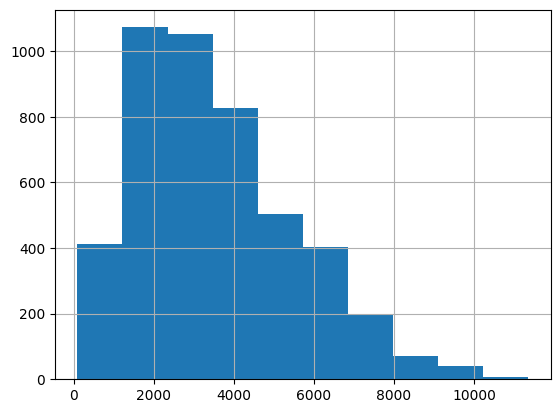

In [7]:
# Convert to tensors
X_train_t = torch.tensor(X_train_clean, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_clean,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_clean,  dtype=torch.float32)

y_train_t = torch.tensor(y_train_clean, dtype=torch.float32).view(-1, 1)
y_val_t   = torch.tensor(y_val_clean,   dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test_clean,  dtype=torch.float32).view(-1, 1)

def make_seq(x):
    # add sequence dimension -> (batch, 1, features)
    return x.unsqueeze(1)

train_ds = TensorDataset(make_seq(X_train_t), y_train_t)
val_ds   = TensorDataset(make_seq(X_val_t),   y_val_t)
test_ds  = TensorDataset(make_seq(X_test_t),  y_test_t)

BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

input_size = X_train_t.shape[1]
print("Input feature size:", input_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Input feature size: 279
Using device: cpu


In [8]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)  # single output: Y_rice

    def forward(self, x):
        # x: (batch, seq_len=1, input_size)
        out, _ = self.lstm(x)
        last = out[:, -1, :]         # (batch, hidden_size)
        out = self.fc(last)          # (batch, 1)
        return out


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y) + 1e-8)


In [9]:
def train_lstm(
    model,
    train_loader,
    val_loader,
    n_epochs=100,
    lr=1e-3,
    clip_norm=1.0
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = RMSELoss()

    history = {"train_rmse": [], "val_rmse": [], "train_r2": [], "val_r2": []}

    for epoch in range(1, n_epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"[Epoch {epoch}] NaN/Inf loss detected, stopping.")
                return history

            loss.backward()
            if clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()

        # ---- evaluate on train & val ----
        model.eval()
        with torch.no_grad():
            # train
            train_preds, train_trues = [], []
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                out = model(xb)
                train_preds.append(out.cpu().numpy())
                train_trues.append(yb.cpu().numpy())
            train_preds = np.vstack(train_preds).ravel()
            train_trues = np.vstack(train_trues).ravel()

            # val
            val_preds, val_trues = [], []
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                out = model(xb)
                val_preds.append(out.cpu().numpy())
                val_trues.append(yb.cpu().numpy())
            val_preds = np.vstack(val_preds).ravel()
            val_trues = np.vstack(val_trues).ravel()

        train_rmse = root_mean_squared_error(train_trues, train_preds)
        val_rmse   = root_mean_squared_error(val_trues,   val_preds)
        train_r2   = r2_score(train_trues, train_preds)
        val_r2     = r2_score(val_trues,   val_preds)

        history["train_rmse"].append(train_rmse)
        history["val_rmse"].append(val_rmse)
        history["train_r2"].append(train_r2)
        history["val_r2"].append(val_r2)

        print(
            f"Epoch {epoch:3d} | "
            f"Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, "
            f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}"
        )

    return history


In [10]:
# Create and train model
lstm_model = LSTMRegressor(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.1)
history = train_lstm(
    lstm_model,
    train_loader,
    val_loader,
    n_epochs=100,
    lr=1e-3,
    clip_norm=1.0,
)

# Evaluate on test set
lstm_model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        out = lstm_model(xb)
        test_preds.append(out.cpu().numpy())
        test_trues.append(yb.cpu().numpy())

test_preds = np.vstack(test_preds).ravel()
test_trues = np.vstack(test_trues).ravel()

test_rmse = root_mean_squared_error(test_trues, test_preds)
test_r2   = r2_score(test_trues, test_preds)

print("\nTest RMSE (LSTM):", test_rmse)
print("Test R²   (LSTM):", test_r2)


Epoch   1 | Train RMSE: 5282.0977, Val RMSE: 5688.7217, Train R²: -24.7468, Val R²: -14.8539
Epoch   2 | Train RMSE: 5282.0586, Val RMSE: 5688.6812, Train R²: -24.7464, Val R²: -14.8537
Epoch   3 | Train RMSE: 5282.0137, Val RMSE: 5688.6343, Train R²: -24.7459, Val R²: -14.8534
Epoch   4 | Train RMSE: 5281.9614, Val RMSE: 5688.5791, Train R²: -24.7454, Val R²: -14.8531
Epoch   5 | Train RMSE: 5281.8989, Val RMSE: 5688.5142, Train R²: -24.7448, Val R²: -14.8527
Epoch   6 | Train RMSE: 5281.8262, Val RMSE: 5688.4390, Train R²: -24.7441, Val R²: -14.8523
Epoch   7 | Train RMSE: 5281.7417, Val RMSE: 5688.3516, Train R²: -24.7433, Val R²: -14.8518
Epoch   8 | Train RMSE: 5281.6440, Val RMSE: 5688.2524, Train R²: -24.7423, Val R²: -14.8513
Epoch   9 | Train RMSE: 5281.5332, Val RMSE: 5688.1401, Train R²: -24.7413, Val R²: -14.8507
Epoch  10 | Train RMSE: 5281.4092, Val RMSE: 5688.0151, Train R²: -24.7400, Val R²: -14.8500
Epoch  11 | Train RMSE: 5281.2700, Val RMSE: 5687.8765, Train R²: -24.

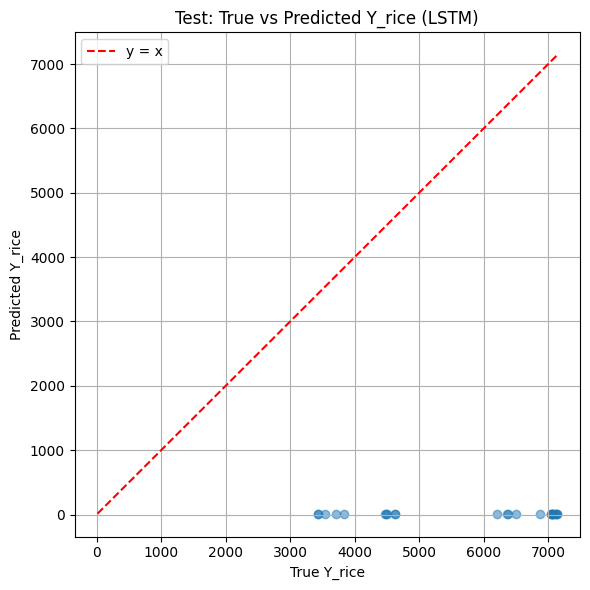

In [11]:
def plot_scatter(y_true, y_pred, title):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label="y = x")
    plt.xlabel("True Y_rice")
    plt.ylabel("Predicted Y_rice")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Validation scatter (use last val_trues / val_preds from training)
# plot_scatter(val_trues, val_preds, "Validation: True vs Predicted Y_rice (LSTM)")

# Test scatter
plot_scatter(test_trues, test_preds, "Test: True vs Predicted Y_rice (LSTM)")
